In [2]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import pandas as pd
cutoff_value = 0.99

In [3]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

random.seed(0)

print("Running...")


thr_std=0.2

E = Events("CheatedRecoFile_1.root")

view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")

u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x

v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x

Running...


In [28]:
print(len(u_x))

9310


In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def AoI(plane, event_number, thresholding=True, no_std=thr_std):
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z[event_number]
        AoI_truevtxx = u_truevtx_x[event_number]
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z[event_number]
        AoI_truevtxx = v_truevtx_x[event_number]
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z[event_number]
        AoI_truevtxx = w_truevtx_x[event_number]
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
    
    return AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx

def plotter(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)


    
    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")

    return 0


# Least Z Probability Calculation

In [21]:
def least_z_scores(plane, event):
    x_view, z_view, adc_view, true_z, true_x = AoI(plane, event)
    z_scores = [None] * len(x_view)
    min_z = np.amin(z_view)
    ind = np.where(min_z)[0]
    min_x = x_view[ind]
    for i in range(len(x_view)):
        z_scores[i] = (z_view[ind] - z_view[i])[0]

    score_max = max(z_scores)
    score_min = min(z_scores)
    
    normalised_scores = (z_scores - score_min) / (score_max - score_min)
    
    return normalised_scores

In [6]:
import scipy as sp
def calculate_probability_lz(plane, event, vertex):
    score = least_z_scores(plane, event)[vertex]
    norm_signal, signal_bin, norm_background, background_bin = normalisepdfs("signal_lz_hist.csv", "back_lz_hist.csv")
    interpolated_function = sp.interpolate.interp1d(signal_bin, norm_signal, kind="cubic", fill_value='extrapolate')
    prob = interpolated_function(score)
    
    for i in range(0, len(prob)):
        if prob[i] >= cutoff_value:
            prob[i] = cutoff_value
    
    return prob


# RPHI Probability Calculation

In [7]:
def rfunc(r):
    return 1/((r+0.01)**(1/2))

def rphi(plane, event_number, thresholding=True, no_std=thr_std, centre_coord=(0,0), func=rfunc, no_sectors=5, centre=0):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]
    
    cen_r = (centred_x**2 + centred_z**2)**0.5
    #distance from central point to every other point
    

    #make the problem tractable (solvable)
    
    weight = rfunc(cen_r)

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre), weights=weight)
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    
    return norm_score

def optimise_phi(plane, event_number, thresholding=True, no_std=thr_std, no_sectors=20, centre=0, plot=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    no_points = len(AoI_x)
    score_arr = np.zeros(no_points)
    for i in range(no_points):
        centre_co = (AoI_z[i], AoI_x[i])
        score_arr[i] = rphi(plane, event_number, centre_coord=centre_co)
    
    ind = np.argmax(score_arr)
    zmin, xmin = AoI_z[ind], AoI_x[ind]
    if plot:
        plotter(plane, event_number, thresholding, no_std)
        plt.plot(zmin, xmin, 'ro')
        plt.show()
    return zmin, xmin, score_arr[ind], score_arr

def rphi_scores(plane, event_number, function=optimise_phi, dependence=np.exp, plot=False, thresholding=True, no_std=thr_std, no_sectors=5):
    AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, event_number, thresholding, no_std)
    Zvert_place, Xvert_place = function(plane, event_number, no_sectors)[0], function(plane, event_number, no_sectors)[1]
    score_max, score_array = function(plane, event_number, no_sectors)[2], function(plane, event_number, no_sectors)[3]
    
    score_min = np.min(score_array)
    
    normalised_scores = (score_array - score_min) / (score_max - score_min)
    
    if plot:
        plt.plot(AoI_z, AoI_x, 'o')
        plt.show()
        plt.plot(AoI_z, normalised_scores, 'ro')
        plt.show()
    return normalised_scores


In [8]:
import scipy as sp
def calculate_probability_rphi(plane, event, vertex):
    score = rphi_scores(plane, event)[vertex]
    norm_signal, signal_bin, norm_background, background_bin = normalisepdfs("signal_rphi_hist.csv", "back_rphi_hist.csv")
    interpolated_function = sp.interpolate.interp1d(signal_bin, norm_signal, kind="cubic", fill_value='extrapolate')
    prob = interpolated_function(score)
    
    for i in range(0, len(prob)):
        if prob[i] >= cutoff_value:
            prob[i] = cutoff_value

    return prob

# QuadVertex Probability Calculation

In [9]:
def line_finder(point1, point2):
    slope = (point1[1] - point2[1])/(point1[0] - point2[0])
    intercept = point1[1] - slope * point1[0]
    return slope, intercept

def line_intersect(slope1, intercept1, slope2, intercept2):
    x_point = (intercept2 - intercept1)/(slope1 - slope2)
    z_point = slope1 * x_point + intercept1
    return x_point, z_point

def check_valid_intersection(point1, point2, point3, point4, range_x, range_z):
    slope1, intercept1 = line_finder(point1, point2)
    slope2, intercept2 = line_finder(point3, point4)
    x_point, z_point = line_intersect(slope1, intercept1, slope2, intercept2)
    x_vertices = [point1[0], point2[0], point3[0], point4[0]]
    z_vertices = [point1[1], point2[1], point3[1], point4[1]]
    x_max, x_min = max(x_vertices), min(x_vertices)
    z_max, z_min = max(z_vertices), min(z_vertices)
    angle1, angle2 = np.arctan(slope1), np.arctan(slope2)
    if x_point > x_min and x_point < x_max:
        if z_point > z_min and z_point < z_max:
            if angle1 < 0.8*angle2 or angle1 > 1.25*angle2: 
                return x_point, z_point
            else:
                return "fail 1", angle1, angle2
        else:
            return "fail 2"
    else:
        return "fail 3"

def get_valid_points(point1, point2, point3, point4, range_x, range_z):
    initial_vertices = [0, 0]
    try:
        initial_vertices[0], initial_vertices[1] = check_valid_intersection(point1, point2, point3, point4, range_x, range_z)
        #print("V1")
        return initial_vertices
    except:
        try:
            initial_vertices[0], initial_vertices[1] = check_valid_intersection(point1, point3, point2, point4, range_x, range_z)
            #print("V2")
            return initial_vertices
        except:
            try:
                initial_vertices[0], initial_vertices[1] = check_valid_intersection(point1, point4, point2, point3, range_x, range_z)
                #print("V3")
                return initial_vertices
            except:
                #print("Fail", point1, point2, point3, point4) 
                return False

def select_random_points(AoI_x, AoI_z, AoI_adc, iterations="scaled", no_std=thr_std):
    if iterations == "scaled":
        iterations = int((len(AoI_x))*4)
        initial_vertex_points = np.zeros((iterations, 2))
        vertex_length = len(AoI_x)
        if vertex_length > 4:
            range_x = (np.amin(AoI_x), np.amax(AoI_x))
            range_z = (np.amin(AoI_z), np.amax(AoI_z))
            for i in range(iterations):
                sample = random.sample(range(0, vertex_length), 4)
                vtxind_1, vtxind_2, vtxind_3, vtxind_4 = sample[0], sample[1], sample[2], sample[3]
                point1, point2, point3, point4 = (AoI_x[vtxind_1], AoI_z[vtxind_1]), (AoI_x[vtxind_2], AoI_z[vtxind_2]), (AoI_x[vtxind_3], AoI_z[vtxind_3]), (AoI_x[vtxind_4], AoI_z[vtxind_4])
                try:
                    initial_vertex_points[i, 0], initial_vertex_points[i, 1] = get_valid_points(point1, point2, point3, point4, range_x, range_z)
                except:
                    pass
                '''
                print("Sample: ", sample)
                print("Slope 1: ", slope1)
                print("Slope 2: ", slope2)
                print("Intercept 1: ", intercept1)
                print("Intercept 2: ", intercept2)
                print("$$$$$$$$    X-point, Z-point    $$$$$$$$: ", x_point, y_point)
                '''
    else:
        initial_vertex_points = np.zeros((iterations, 2))
        vertex_length = len(AoI_x)
        if vertex_length > 4:
            range_x = (np.amin(AoI_x), np.amax(AoI_x))
            range_z = (np.amin(AoI_z), np.amax(AoI_z))
            for i in range(iterations):
                sample = random.sample(range(0, vertex_length), 4)
                vtxind_1, vtxind_2, vtxind_3, vtxind_4 = sample[0], sample[1], sample[2], sample[3]
                point1, point2, point3, point4 = (AoI_x[vtxind_1], AoI_z[vtxind_1]), (AoI_x[vtxind_2], AoI_z[vtxind_2]), (AoI_x[vtxind_3], AoI_z[vtxind_3]), (AoI_x[vtxind_4], AoI_z[vtxind_4])
                try:
                    initial_vertex_points[i, 0], initial_vertex_points[i, 1] = get_valid_points(point1, point2, point3, point4, range_x, range_z)
                except:
                    pass
    return initial_vertex_points

def heatmap4points(plane, event_number, thresholding=False, no_std=thr_std, iterations=10000, bins=100):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    vertex_points = select_random_points(AoI_x, AoI_z, AoI_adc, iterations)
    #print(vertex_points)
    vertex_points = vertex_points[~np.all(vertex_points == 0, axis=1)] #removes all the 0,0 vertices
    
    #print(vertex_points)
    histvertex = plt.hist2d(vertex_points[:,1], vertex_points[:,0], bins=(bins, bins), cmap=plt.cm.jet)
    plt.title(str(plane) + str(event_number))
    #stringy = str(plane) + str(event_number) + ".png"
    #plt.savefig(stringy)
    #plt.show()
    
    histogram_array = histvertex[0]
    #print(histogram_array)
    max_value = np.amax(histogram_array)
    indices = np.where(histogram_array == max_value)
    #print("Indices: ", indices)
    z_value = histvertex[1][indices[0]]
    x_value = histvertex[2][indices[1]]
    #print("Z_value: ", z_value)
    #print("X_value: ", x_value)

    return z_value[0], x_value[0], histogram_array, histvertex[1], histvertex[2]

def quadvertex_scores(plane, event_number, binwidth=(100,100), binradius=3):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number)
    
    h, zedges, xedges = heatmap4points(plane, event_number)[2], heatmap4points(plane, event_number)[3], heatmap4points(plane, event_number)[4]

    zbins = np.digitize(AoI_z, zedges) - 2 
    xbins = np.digitize(AoI_x, xedges) - 2
    
    zxbins = np.concatenate((zbins[...,None],xbins[...,None]), axis=1) 
    
    weights = h[zxbins[:,0], zxbins[:,1]]
    
    scores = weights/np.amax(weights)
    return scores


In [10]:
import scipy as sp
def calculate_probability_quad(plane, event, vertex):
    score = quadvertex_scores(plane, event)[vertex]
    norm_signal, signal_bin, norm_background, background_bin = normalisepdfs("signal_quad_hist.csv", "back_quad_hist.csv")
    interpolated_function = sp.interpolate.interp1d(signal_bin, norm_signal, kind="cubic", fill_value='extrapolate')
    prob = interpolated_function(score)
    
    for i in range(0, len(prob)):
        if prob[i] >= cutoff_value:
            prob[i] = cutoff_value
    
    return prob

In [16]:
def generate_all_scores(plane, event):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event)
    r_scores = [None] * len(AoI_x)
    for i in range(len(AoI_x)):
        r_scores[i] = ((AoI_x[i] - AoI_truevtxx)**2 + (AoI_z[i] - AoI_truevtxz)**2)**(0.5)
        
    qd_scores = quadvertex_scores(plane, event)
    lz_scores = least_z_scores(plane, event)
    rp_scores = rphi_scores(plane, event)
    
    return lz_scores, rp_scores, qd_scores, r_scores

C:\Users\alexg\AppData\Local\Temp\ipykernel_8012\2088040020.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_8012\2088040020.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1


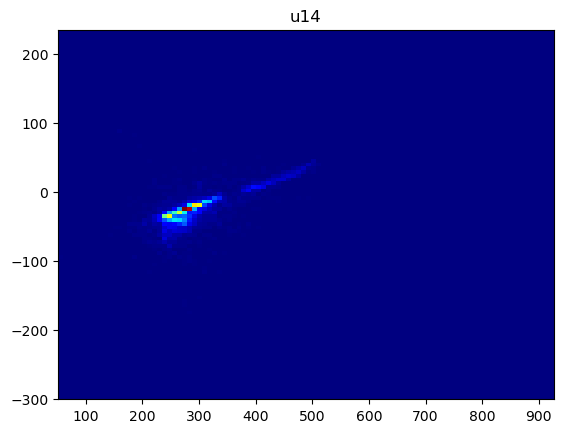

In [22]:
lz_scores, rp_scores, qd_scores, r_scores = generate_all_scores("u", 14)

In [25]:
import pandas as pd

def generate_score_dataframe(plane, event):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event)
    r_scores = [None] * len(AoI_x)
    for i in range(len(AoI_x)):
        r_scores[i] = ((AoI_x[i] - AoI_truevtxx)**2 + (AoI_z[i] - AoI_truevtxz)**2)**(0.5)
        
    qd_scores = quadvertex_scores(plane, event)
    lz_scores = least_z_scores(plane, event)
    rp_scores = rphi_scores(plane, event)
    combi_dataframe = pd.DataFrame(list(zip(lz_scores, rp_scores, qd_scores, r_scores)),columns =['LZ Scores', 'RPHI Scores', 'QuadVertex Scores', 'Distance from vertex'])
    
    return combi_dataframe

     LZ Scores  RPHI Scores  QuadVertex Scores  Distance from vertex
0     0.481124     0.323912           0.026316             71.634224
1     0.521206     0.339514           0.078947             49.137464
2     0.536890     0.438518           0.216374             41.862961
3     0.565645     0.529912           0.040936             28.023915
4     0.595271     0.765702           0.017544              9.516489
..         ...          ...                ...                   ...
512   0.593528     0.412165           0.000000             42.286304
513   0.593528     0.389918           0.000000             41.117770
514   0.592657     0.406833           0.002924             45.290970
515   0.592657     0.392056           0.000000             42.180260
516   0.592657     0.380696           0.000000             41.256376

[517 rows x 4 columns]


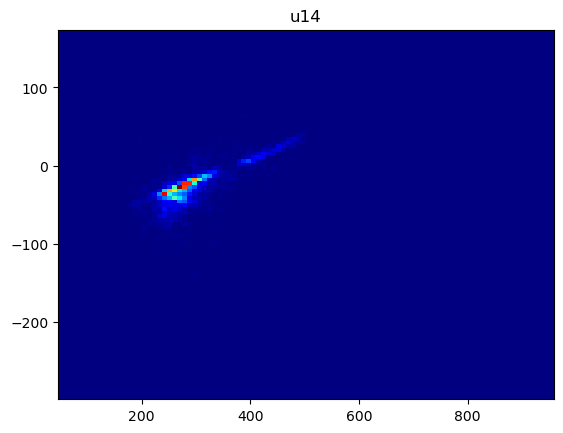

In [26]:
print(generate_score_dataframe("u", 14))

In [84]:
def generate_train_test_index_split(plane, length_divisor=5):
    #The train-val-test splitting is: 60-20-20
    length = len(u_x) / length_divisor
    all_events = range(0, int(round(length)))
    train_indices = random.sample(range(0, int(round(length))), int(round(0.6*length)))
    leftover_indices = [idx for idx in all_events if idx not in train_indices]
    val_indices = random.sample(leftover_indices, int(round(0.2*length)))
    test_indices = [idx for idx in leftover_indices if idx not in val_indices]
    
    return train_indices, val_indices, test_indices

def generate_train_test_split(plane, train_indices, val_indices, test_indices):
    df_train = pd.DataFrame(columns=['LZ Scores', 'RPHI Scores', 'QuadVertex Scores', 'Distance from vertex'])
    df_val = pd.DataFrame(columns=['LZ Scores', 'RPHI Scores', 'QuadVertex Scores', 'Distance from vertex'])
    df_test = pd.DataFrame(columns=['LZ Scores', 'RPHI Scores', 'QuadVertex Scores', 'Distance from vertex'])
    
    for i in tqdm(train_indices):
        temp_dataframe = generate_score_dataframe(plane, i)
        df_train = pd.concat([df_train, temp_dataframe])
        
    for i in tqdm(val_indices):
        temp_dataframe = generate_score_dataframe(plane, i)
        df_val = pd.concat([df_val, temp_dataframe])
        
    for i in tqdm(test_indices):
        temp_dataframe = generate_score_dataframe(plane, i)
        df_test = pd.concat([df_test, temp_dataframe])
        
    return df_train, df_val, df_test

In [ ]:

train_indices, val_indices, test_indices = generate_train_test_index_split("u")

df_train, df_val, df_test = generate_train_test_split("u", train_indices, val_indices, test_indices)

df_train = df_train.dropna()
df_val = df_val.dropna()
df_test = df_test.dropna()

  0%|                                                                                 | 1/1117 [00:00<11:46,  1.58it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_8012\2088040020.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_8012\2088040020.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  0%|▏                                                                                | 2/1117 [00:01<11:07,  1.67it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_8012\2088040020.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_8012\2088040020.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  1%|▌                                                          

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x0000023E9D259A60> (for post_execute):


KeyboardInterrupt: 

# BDT Creation - Loading the datasets

In [40]:
'''
df_train.to_csv("df_train.csv")
df_val.to_csv("df_val.csv")
df_test.to_csv("df_test.csv")
'''

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
x_train, y_train = df_train[['LZ Scores', 'RPHI Scores', 'QuadVertex Scores']], df_train[['Distance from vertex']]
x_val, y_val = df_val[['LZ Scores', 'RPHI Scores', 'QuadVertex Scores']], df_val[['Distance from vertex']]

In [ ]:
x_train.describe()
y_train.describe()

In [ ]:
# Create the BDT with a base decision tree classifier (this is the default base classifier, included for illustration)
model = DecisionTreeRegressor(max_leaf_nodes=50, random_state=0)
# Fit the BDT to the training set
model.fit(x_train, y_train)

In [ ]:
preds_val = model.predict(x_val)
mae = mean_absolute_error(y_val, preds_val)

In [ ]:
print(mae)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(x_train, y_train)
preds = forest_model.predict(x_val)
print(mean_absolute_error(y_val, preds))